In [1]:
#
# Copyright 2016 The BigDL Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
#
# Copyright 2018 The TensorFlow Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
#
# This example classifies movie reviews as positive or negative using the text of the review,
# and is adapted from
# https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/basic_text_classification.ipynb

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [2]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_342"
OpenJDK Runtime Environment (build 1.8.0_342-8u342-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.342-b07, mixed mode)


**Install BigDL Orca**

You can install the latest pre-release version using `pip install --pre --upgrade bigdl-orca`. 

In [3]:
# Install latest pre-release version of BigDL Orca 
# Installing BigDL Orca from pip will automatically install pyspark and their dependencies.
!pip install --pre --upgrade bigdl-orca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.9 MB 1.6 MB/s 
     |████████████████████████████████| 71.0 MB 479 bytes/s 
     |████████████████████████████████| 53.5 MB 117 kB/s 
     |████████████████████████████████| 35.4 MB 498 kB/s 
     |████████████████████████████████| 218.4 MB 50 kB/s 
INFO: pip is looking at multiple versions of bigdl-orca to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 21.9 MB 1.3 MB/s 
     |████████████████████████████████| 53.5 MB 88 kB/s 
     |████████████████████████████████| 48.2 MB 1.6 MB/s 
     |████████████████████████████████| 197 kB 57.6 MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.6-py2.py3-none-any.whl size=218814407 sha256=8f17b581037a63aa30460063e24fc7777ef3522fa9443ece74ac71a570df2822
  Stored in directory: /root/.cache/pip/wheels/f1/42/b0/ba397759613f4f

In [4]:
# Install required dependencies
# The tutorial below only supports TensorFlow 1.15
!pip install tensorflow==1.15 tensorflow-datasets==2.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 26 kB/s 
     |████████████████████████████████| 3.1 MB 37.2 MB/s 
     |████████████████████████████████| 50 kB 8.8 MB/s 
     |████████████████████████████████| 3.8 MB 42.0 MB/s 
     |████████████████████████████████| 503 kB 54.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=3e479972a7871d793774868b164cfc674ab8e11802c19ef22f017ca4674b43f9
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      

In [5]:
import tensorflow as tf
print(tf.__version__)

1.15.0


## **Distributed Keras using Orca APIs**
In this guide we will describe how to scale out Keras programs using Orca in 5 simple steps.

In [6]:
#import necessary libraries and modules
import argparse
from time import time
from tabulate import tabulate
import matplotlib.pyplot as plt
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext
from bigdl.orca.learn.tf.estimator import Estimator


### **Step 1: Define the Model**
You may define your model, loss and optimizer in the same way as in any standard (single node) Keras program.

In [7]:
from tensorflow import keras

# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### **Step 2: Define Train Dataset**

**Prepare Dataset**

The IMDB dataset comes packaged with TensorFlow. It has already been preprocessed such that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.


In [9]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# The first indices are reserved
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

17465344/17464789 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/keras/datasets/imdb.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/keras/datasets/imdb.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


Training entries: 25000, labels: 25000
1646592/1641221 [==============================] - 0s 0us/step


In [10]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

Transform a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). 
num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.

In [11]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data, 
                                                        value=word_index["<PAD>"], 
                                                        padding='post', 
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data, 
                                                       value=word_index["<PAD>"], 
                                                       padding='post',  
                                                       maxlen=256)

Define the dataset using standard `tf.data.Dataset`.

In [12]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

train_dataset = tf.data.Dataset.from_tensor_slices((partial_x_train, partial_y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

### Step 3: Define the train method

In [13]:
def train_test(cores, epochs):
  OrcaContext.log_output = True
  init_orca_context(cluster_mode="local", cores=cores, memory="2g")
  est = Estimator.from_keras(keras_model=model, backend='bigdl')
  tic = time()
  est.fit(
    data=train_dataset,
    batch_size=32,
    epochs=epochs,
    validation_data=validation_dataset
  )
  tac = time()
  fit_time = tac-tic
  return fit_time

### Step 4: Define the iteration method through multiple cores numbers

In [14]:
def grid_search(min_cores=1, max_cores=4, epochs=1):
  results = []
  for cores in range(min_cores, max_cores+1):
    fit_time = train_test(cores, epochs)
    results.append((cores, fit_time))
  return results

def visualize(model_name, epochs, results):
    xs, ys = [], []
    for datum in results:
      cores, fit_time = datum
      xs.append(cores)
      ys.append(fit_time)
      plt.bar(xs, ys)
    items = zip(xs, ys)
    plt.title(f"{model_name}: {epochs} epochs")
    plt.xlabel("Cores")
    plt.ylabel("Train time (sec)")
    plt.plot()

def tabulate_results(model_name, epochs, results):
    xs, ys = [], []
    for datum in results:
      cores, fit_time = datum
      xs.append(cores)
      ys.append(fit_time/1000)
    items = zip(xs, ys)
    print(tabulate(items, headers=["Cores", "Train time (sec)"], tablefmt="github"))

### Iterate from 1 to 4 cores for 1 epoch

In [15]:
model_name = "Simple Sequential"
min_cores=1
max_cores=4
epochs=1
results1 = grid_search(
  min_cores=min_cores,
  max_cores=max_cores,
  epochs=epochs
)

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/core/lib/all-2.1.0-20220728.053003-14.jar pyspark-shell 
Successfully got a SparkContext








Instructions for updating:
Use `tf.cast` instead.





creating: createZooKerasBinaryCrossEntropy
creating: createLoss
creating: createZooKerasBinaryAccuracy
creating: createFakeOptimMethod
creating: createTFValidationMethod
creating: createTFValidationMethod


creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 19:10:13.454 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 19:10:13.465 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 1
2022-09-18 19:10:14.961 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 19:10:14.974 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 19:10:43.127 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.InternalDistriOptimizer$ - TFTrainingHelperV2[TFParkTraining] isTorch is false
2022-09-18 19:10:43.133 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - caching training rdd ...
2022-09-18 

/usr/local/lib/python3.7/dist-packages/bigdl/orca/common.py:251: Warning: Use an existing SparkContext, cluster_mode is determined by the existing SparkContext
  "cluster_mode is determined by the existing SparkContext", Warning)


creating: createZooKerasBinaryCrossEntropy
creating: createLoss
creating: createZooKerasBinaryAccuracy
creating: createFakeOptimMethod
creating: createTFValidationMethod
creating: createTFValidationMethod
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 19:11:12.410 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 19:11:12.413 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 1
2022-09-18 19:11:12.414 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 19:11:12.416 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 19:11:34.832 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.Internal

creating: createZooKerasBinaryCrossEntropy
creating: createLoss
creating: createZooKerasBinaryAccuracy
creating: createFakeOptimMethod
creating: createTFValidationMethod
creating: createTFValidationMethod
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 19:12:00.525 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 19:12:00.533 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 1
2022-09-18 19:12:00.534 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 19:12:00.540 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 19:12:24.041 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.Internal

creating: createZooKerasBinaryCrossEntropy
creating: createLoss
creating: createZooKerasBinaryAccuracy
creating: createFakeOptimMethod
creating: createTFValidationMethod
creating: createTFValidationMethod
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 19:12:48.736 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 19:12:48.739 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 1
2022-09-18 19:12:48.740 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 19:12:48.742 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 19:13:13.665 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.Internal

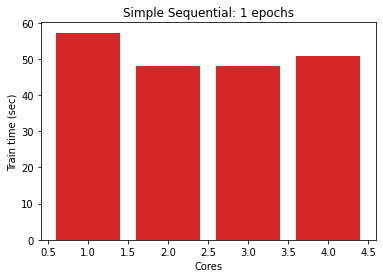

In [16]:
visualize(model_name, epochs, results1)

In [17]:
tabulate_results(model_name, epochs, results1)

|   Cores |   Train time (sec) |
|---------|--------------------|
|       1 |          0.0572326 |
|       2 |          0.0480035 |
|       3 |          0.0480735 |
|       4 |          0.0506727 |


### Train for 10 epochs

In [18]:
model_name = "LeNet"
min_cores=1
max_cores=4
epochs=10
results2 = grid_search(
  min_cores=min_cores,
  max_cores=max_cores,
  epochs=epochs
)

Initializing orca context


creating: createZooKerasBinaryCrossEntropy
creating: createLoss
creating: createZooKerasBinaryAccuracy
creating: createFakeOptimMethod
creating: createTFValidationMethod
creating: createTFValidationMethod
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 19:14:07.319 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 19:14:07.322 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 1
2022-09-18 19:14:07.323 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 19:14:07.327 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 19:14:35.110 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.Internal

creating: createZooKerasBinaryCrossEntropy
creating: createLoss
creating: createZooKerasBinaryAccuracy
creating: createFakeOptimMethod
creating: createTFValidationMethod
creating: createTFValidationMethod
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 19:18:01.486 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 19:18:01.494 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 1
2022-09-18 19:18:01.500 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 19:18:01.504 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 19:18:30.001 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.Internal

creating: createZooKerasBinaryCrossEntropy
creating: createLoss
creating: createZooKerasBinaryAccuracy
creating: createFakeOptimMethod
creating: createTFValidationMethod
creating: createTFValidationMethod
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 19:21:36.225 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 19:21:36.232 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 1
2022-09-18 19:21:36.232 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 19:21:36.234 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 19:22:04.195 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.Internal

creating: createZooKerasBinaryCrossEntropy
creating: createLoss
creating: createZooKerasBinaryAccuracy
creating: createFakeOptimMethod
creating: createTFValidationMethod
creating: createTFValidationMethod
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 19:25:29.004 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 19:25:29.013 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 1
2022-09-18 19:25:29.015 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 19:25:29.018 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 19:25:59.466 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.Internal

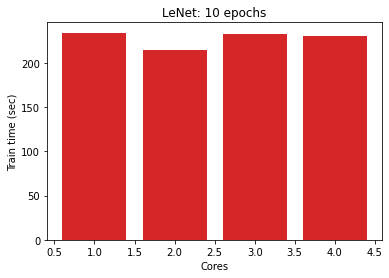

In [19]:
visualize(model_name, epochs, results2)

In [20]:
tabulate_results(model_name, epochs, results2)

|   Cores |   Train time (sec) |
|---------|--------------------|
|       1 |           0.233965 |
|       2 |           0.214469 |
|       3 |           0.232489 |
|       4 |           0.230575 |
